# Captcha Model Predictor


# Importing Libraries

In [ ]:
import albumentations
import numpy as np
import pandas as pd
import os
import glob
import random
from pprint import pprint
from tqdm import tqdm

# PyTorch Model
import torch
from torch import nn
from torch.nn import functional as F

# Dataset Loading
from PIL import Image
from PIL import ImageFile

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Model Training
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download aadhavvignesh/captcha-images
! unzip /content/captcha-images.zip -d /content/Dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/MfCz2952J2.jpg  
  inflating: /content/Dataset/Mg9dqLIAa8.jpg  
  inflating: /content/Dataset/MjO1Js6XgA.jpg  
  inflating: /content/Dataset/MlwATsH769.jpg  
  inflating: /content/Dataset/MmCq0lD094.jpg  
  inflating: /content/Dataset/MnlPW1bSN8.jpg  
  inflating: /content/Dataset/Mo3oiCENk3.jpg  
  inflating: /content/Dataset/Moi63rdC9l.jpg  
  inflating: /content/Dataset/Mp56Jdz6Wc.jpg  
  inflating: /content/Dataset/Mq0e35486R.jpg  
  inflating: /content/Dataset/MrI5168nUz.jpg  
  inflating: /content/Dataset/Mrd8nD748x.jpg  
  inflating: /content/Dataset/Mro5dp3lve.jpg  
  inflating: /content/Dataset/Mru69H0kAL.jpg  
  inflating: /content/Dataset/MtF4pK9W71.jpg  
  inflating: /content/Dataset/MtKOR3iGo1.jpg  
  inflating: /content/Dataset/Mts42U4pmp.jpg  
  inflating: /content/Dataset/MuXNFG6TNq.jpg  
  inflating: /content/Dataset/MxJhc90qT1.jpg  
  inflating: /content/Dataset/Mxjv8h04Yl.jpg  
  inflati

In [ ]:
# Configurations for the files
DIR = "Dataset"
BATCH_SIZE = 16
IMG_HEIGHT = 75
IMG_WIDTH = 300
EPOCHS = 150
NUM_WORKERS = 8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


# Image Analysis
Show the dataset path and labels of random images in the dataset.

In [ ]:
paths = []
labels = []
for image in os.listdir(DIR):
    paths.append(os.path.join(DIR, image))
    labels.append(image.split(".")[0])

df = pd.DataFrame({
    "paths": paths,
    "labels": labels
})

df.head()

,paths,labels
0,Dataset/j7UD7X7DO6.jpg,j7UD7X7DO6
1,Dataset/9sATSPOX60.jpg,9sATSPOX60
2,Dataset/f159NWHxnv.jpg,f159NWHxnv
3,Dataset/byYBCP5YE1.jpg,byYBCP5YE1
4,Dataset/52l00PM9hS.jpg,52l00PM9hS


In [ ]:
def show_random_images(df, column_name):
    f = plt.figure(figsize=(10,10))
    i=1
    for i in range(16):
        i += 1
        ax = f.add_subplot(4,4,i)
        sample = random.choice(df[column_name])
        image = mpimg.imread(sample)
        ax.set_title(sample.split("/")[-1])
        plt.imshow(image)


Display a few random captcha images.

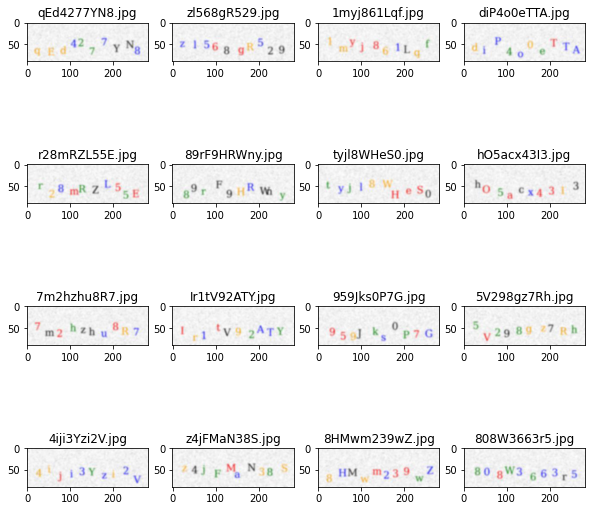

In [ ]:
show_random_images(df, "paths")

# Model Definition

Model Architecture: we use two CNN layers to get information from the images, and then use a GRU to sequentially parse each letter available. 

As for the loss function, we use the CTCLoss (Connectionist Temporal Classification Loss) to find the error sequentially.

In [ ]:
def get_loss_function(x, bs, targets):
    log_softmax_values = F.log_softmax(x, 2)

    input_lengths = torch.full(
        size=(bs,), fill_value=log_softmax_values.size(0), dtype=torch.int32
    )

    target_lengths = torch.full(
        size=(bs,), fill_value=targets.size(1), dtype=torch.int32
    )

    return nn.CTCLoss(blank=0)(log_softmax_values, targets, input_lengths, target_lengths)

In [ ]:
class MyCaptchaModel(nn.Module):
    def __init__(self, num_chars):
        super(MyCaptchaModel, self).__init__()
        
        # CNN Layer
        self.conv1 = nn.Conv2d(3, 128, kernel_size=(3,3), padding=(1,1))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3,3), padding=(1,1))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
        
        # RNN Layer Preprocess
        self.linear1 = nn.Linear(1152, 64)
        self.drop1 = nn.Dropout(0.2)
        
        # LSTM GRU
        self.gru = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)
        self.output = nn.Linear(64, num_chars+1)
        
        
    def forward(self, images, targets=None):  
        bs, channel, height, width = images.size()
        
        x = F.relu(self.conv1(images))
        x = self.maxpool1(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        x = x.permute(0, 3, 1, 2)
        x = x.view(bs, x.size(1), -1)

        x = self.linear1(x)
        x = self.drop1(x)

        x, _ = self.gru(x)
        x = self.output(x)
        x = x.permute(1, 0, 2)

        if targets is not None:
            loss = get_loss_function(x, bs, targets)
            return x, loss
        
        return x, None

Next, we create the train and evaluation functions. These are basically the functions that run for each step, and output the loss of the function. The train function also implements backpropagation and adjusts the weights of the model.

In [ ]:
def train_function(model, data_loader, optimizer):
    model.train()
    fin_loss = 0
    tk = tqdm(data_loader, total=len(data_loader))
    for data in tk:
        for k, v in data.items():
            data[k] = v.to(DEVICE)
        
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step()
        fin_loss += loss.item()

    return fin_loss / len(data_loader)


def eval_function(model, data_loader):
    model.eval()
    fin_loss = 0
    fin_preds = []
    with torch.no_grad(): 
        tk = tqdm(data_loader, total=len(data_loader))
        for data in tk:
            for k, v in data.items():
                data[k] = v.to(DEVICE)
            
            batch_preds, loss = model(**data)
            fin_loss += loss.item()
            fin_preds.append(batch_preds)

        return fin_preds, fin_loss / len(data_loader)

# Parse Images & Encode Labels

Now, we get the correct labels for each image. The targets are found in the images' filename, so we parse these and convert them into lists. Once everything is converted into a list, we use sklearn's train_test_split to shuffle and split our train and test sets.

In [ ]:
def encode_targets():
  # Load images from files
  image_files = glob.glob(os.path.join(DIR, "*.jpg"))
  image_files_png = glob.glob(os.path.join(DIR, "*.png"))
  image_files.extend(image_files_png)
  targets_orig = [x.split("/")[-1].split(".")[0] for x in image_files]
  targets = [[c for c in x] for x in targets_orig]
  targets_flat = [c for clist in targets for c in clist] # squeeze

  # Encode images
  lbl_enc = LabelEncoder()
  lbl_enc.fit(targets_flat)

  targets_enc = [lbl_enc.transform(x) for x in targets]
  targets_enc = np.array(targets_enc) + 1 # transform to np and remove 0 index

  return image_files, targets_enc, targets_orig, lbl_enc

In [ ]:
# Train-test split
image_files, targets_enc, targets_orig, lbl_enc = encode_targets()

(train_imgs, test_imgs, train_targets, test_targets, _, test_orig_targets) = train_test_split(
    image_files, targets_enc, targets_orig, test_size=0.1, random_state=0)

## Dataset Classifier Class

We create a DatasetClassifier Class to read and process the images, and then use PyTorch's data_loader. This makes the training process smoother and makes it easier to separate the train set by the configured batch size.

In [ ]:
ImageFile.LoadTruncatedImages = True

class DatasetClassifier:
    def __init__(self, image_paths, targets, resize=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.aug = albumentations.Compose(
            [
             albumentations.Normalize(always_apply=True)
            ]
            )
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert("RGB")
        target = self.targets[item]
        
        if self.resize is not None:
            image = image.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)
        
        image = np.array(image)
        augmented = self.aug(image=image)
        image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {
            "images": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(target, dtype=torch.long)
        }

In [ ]:
# Classify images, load using pytorch's DataLoader
train_dataset = DatasetClassifier(
    image_paths=train_imgs, targets=train_targets, resize=(IMG_HEIGHT, IMG_WIDTH)
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

test_dataset = DatasetClassifier(
    image_paths=test_imgs, targets=test_targets, resize=(IMG_HEIGHT, IMG_WIDTH)
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Create Model, Optimizers, Callbacks

We now load the model class we developed earlier. We use the Adam Optimizer with a learning rate of 3e-4. We also add callback functions that would adjust the learning rate when it plateaus, and implement early stopping whenever the loss doesn't decrease anymore. These callback functions prevent overfitting of the model.

In [ ]:
# Load the models
model = MyCaptchaModel(num_chars=len(lbl_enc.classes_))
model.to(DEVICE)

# Create optimizer and callbacks
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=5, verbose=True
)

In [ ]:
def early_stopping(patience, count, prev_loss, current_loss, threshold):
    if abs(prev_loss - current_loss) < threshold and count >= patience:
        return "stop" 
    elif abs(prev_loss - current_loss) < threshold:
        return "count"
    else:
        return False

## Decoding the Predictions
Next, we create a function to interpret the predictions. As the predictions are still using the label encoder from earlier, we use the inverse transform for these. If the prediction is not found in the encoder's classes, we assign it as a "filler" and will clean it later on.

In [ ]:
def decode_predictions(preds, encoder):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j,:]:
            k = k - 1
            if k == -1:
                temp.append("-")
            else:
                temp.append(encoder.inverse_transform([k])[0])
        tp = "".join(temp)
        cap_preds.append(tp)
    return cap_preds

## Running the training model
This process loads in everything we developed earlier. We load the data into the data_loader, and then create predictions based on the CRNN model. The CTCLoss gives out the loss, and then we adjust the weights to create better predictions in the following epoch. Once the loss plateaus, we save the model and use this for predictions.

In [ ]:
patience = 6
count = 0
prev_train_loss = 0
threshold = 0.05
loss = []

for epoch in range(EPOCHS):
    train_loss = train_function(model, train_loader, optimizer)
    valid_preds, valid_loss = eval_function(model, test_loader)
    valid_cap_preds = []

    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
        valid_cap_preds.extend(current_preds)
        
    pprint(list(zip(test_orig_targets, valid_cap_preds))[15:20])
    print(f"Epoch: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}")
    
    res = early_stopping(patience, count, prev_train_loss, train_loss, threshold)
    
    loss.append(train_loss)
    
    if res == "stop":
        print("Early Stopping Implemented.")
        final_epoch = epoch
        break
    elif res == "count" and train_loss < 0.2:
        count += 1
        print(f"Patience at {patience-count}")
    else:
        prev_train_loss = train_loss

  0%|          | 0/563 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 63/63 [00:04<00:00, 13.36it/s]


[('r6S5KIpx0s',
  '---------------------------------------------------------------------------'),
 ('ge07ByTGkv',
  '---------------------------------------------------------------------------'),
 ('e4fjfGW18W',
  '---------------------------------------------------------------------------'),
 ('Amtz6zqWc9',
  '---------------------------------------------------------------------------'),
 ('YSfMLOT821',
  '---------------------------------------------------------------------------')]
Epoch: 0, train_loss: 5.032614022758037, valid_loss: 4.247668606894357


100%|██████████| 63/63 [00:05<00:00, 10.87it/s]


[('r6S5KIpx0s',
  '---------------------------------------------------------------------------'),
 ('ge07ByTGkv',
  '---------------------------------------------------------------------------'),
 ('e4fjfGW18W',
  '---------------------------------------------------------------------------'),
 ('Amtz6zqWc9',
  '---------------------------------------------------------------------------'),
 ('YSfMLOT821',
  '---------------------------------------------------------------------------')]
Epoch: 1, train_loss: 4.23924105205502, valid_loss: 4.244979487525092


100%|██████████| 63/63 [00:04<00:00, 13.02it/s]


[('r6S5KIpx0s',
  '---------------------------------------------------------------------------'),
 ('ge07ByTGkv',
  '---------------------------------------------------------------------------'),
 ('e4fjfGW18W',
  '---------------------------------------------------------------------------'),
 ('Amtz6zqWc9',
  '---------------------------------------------------------------------------'),
 ('YSfMLOT821',
  '---------------------------------------------------------------------------')]
Epoch: 2, train_loss: 4.239420314029944, valid_loss: 4.246983111850799


100%|██████████| 63/63 [00:05<00:00, 10.88it/s]


[('r6S5KIpx0s',
  '---------------------------------------------------------------------------'),
 ('ge07ByTGkv',
  '---------------------------------------------------------------------------'),
 ('e4fjfGW18W',
  '---------------------------------------------------------------------------'),
 ('Amtz6zqWc9',
  '---------------------------------------------------------------------------'),
 ('YSfMLOT821',
  '---------------------------------------------------------------------------')]
Epoch: 3, train_loss: 4.23928791337496, valid_loss: 4.246649961622935


100%|██████████| 63/63 [00:05<00:00, 11.57it/s]


[('r6S5KIpx0s',
  '---------------------------------------------------------------------------'),
 ('ge07ByTGkv',
  '---------------------------------------------------------------------------'),
 ('e4fjfGW18W',
  '---------------------------------------------------------------------------'),
 ('Amtz6zqWc9',
  '---------------------------------------------------------------------------'),
 ('YSfMLOT821',
  '---------------------------------------------------------------------------')]
Epoch: 4, train_loss: 4.238959552974938, valid_loss: 4.246610490102617


100%|██████████| 63/63 [00:05<00:00, 11.71it/s]


[('r6S5KIpx0s',
  '---------------------------------------------------------------------------'),
 ('ge07ByTGkv',
  '---------------------------------------------------------------------------'),
 ('e4fjfGW18W',
  '---------------------------------------------------------------------------'),
 ('Amtz6zqWc9',
  '---------------------------------------------------------------------------'),
 ('YSfMLOT821',
  '---------------------------------------------------------------------------')]
Epoch: 5, train_loss: 4.237933798327539, valid_loss: 4.245513953859844


100%|██████████| 63/63 [00:04<00:00, 13.08it/s]


[('r6S5KIpx0s',
  '---------------------------------------------------------------------------'),
 ('ge07ByTGkv',
  '---------------------------------------------------------------------------'),
 ('e4fjfGW18W',
  '---------------------------------------------------------------------------'),
 ('Amtz6zqWc9',
  '---------------------------------------------------------------------------'),
 ('YSfMLOT821',
  '---------------------------------------------------------------------------')]
Epoch: 6, train_loss: 4.234559672340406, valid_loss: 4.246201454647004


100%|██████████| 63/63 [00:05<00:00, 11.96it/s]


[('r6S5KIpx0s',
  '---------------------------------------------------------------------------'),
 ('ge07ByTGkv',
  '---------------------------------------------------------------------------'),
 ('e4fjfGW18W',
  '---------------------------------------------------------------------------'),
 ('Amtz6zqWc9',
  '---------------------------------------------------------------------------'),
 ('YSfMLOT821',
  '---------------------------------------------------------------------------')]
Epoch: 7, train_loss: 4.168862377559736, valid_loss: 4.0378514017377585


100%|██████████| 63/63 [00:04<00:00, 13.11it/s]


[('r6S5KIpx0s',
  '-------3-----6-----8-------------K-------1------8-----9----0-------0-------'),
 ('ge07ByTGkv',
  '-------------3--------------------R----0--------1----3-------6------1------'),
 ('e4fjfGW18W',
  '-------1-----4------6-------------1------2---W---------1---8-------W-------'),
 ('Amtz6zqWc9',
  '---------M---------1--------2-----6-----------8------W------2--------------'),
 ('YSfMLOT821',
  '--------4---8-------1-------M------------0-----0------8-------------1------')]
Epoch: 8, train_loss: 3.6265309847904565, valid_loss: 2.826513585590181


100%|██████████| 63/63 [00:04<00:00, 13.07it/s]


[('r6S5KIpx0s',
  '-------3-----6-----S--------7---KK-------1------6-----x----0-------s-------'),
 ('ge07ByTGkv',
  '-----g-------v-----o-------7------R----y--------1----3-------k------v------'),
 ('e4fjfGW18W',
  '-------e-----4------F------7------F------3----W--------1---8-------W-------'),
 ('Amtz6zqWc9',
  '---------M--8------1--------2-----6------7----d------W------7------9-------'),
 ('YSfMLOT821',
  '--------Y---S-------1-------M-----1------0-----1------8-------5-----1------')]
Epoch: 9, train_loss: 2.3103088034617962, valid_loss: 1.5964967807133992


100%|██████████| 63/63 [00:04<00:00, 13.03it/s]


[('r6S5KIpx0s',
  '-------r-----6-----S--------5---KK-------1------b-----x----0-------s-------'),
 ('ge07ByTGkv',
  '-----g-------v-----0-------7------B----y--------1----G-------k------v------'),
 ('e4fjfGW18W',
  '-------e-----4------F------i------F------r----W--------1---8-------W-------'),
 ('Amtz6zqWc9',
  '---------A--m------t--------z-----6------v----d------W------c------9-------'),
 ('YSfMLOT821',
  '--------Y---S-------1-------M-----1------Q-----1------8-------2-----1------')]
Epoch: 10, train_loss: 1.3723091678975108, valid_loss: 0.9003681133663843


100%|██████████| 63/63 [00:04<00:00, 13.09it/s]


[('r6S5KIpx0s',
  '-------r-----6-----S--------5----K-------1------b-----x----0-------s-------'),
 ('ge07ByTGkv',
  '-----g-------e-----0-------7------B----y--------1----G-------k------v------'),
 ('e4fjfGW18W',
  '-------e-----4------f------j------f------r----W--------1---8-------W-------'),
 ('Amtz6zqWc9',
  '---------A--m------t--------z-----6------z----d------W------c------9-------'),
 ('YSfMLOT821',
  '--------Y---S-------1-------M-----1------Q-----1------8-------2-----1------')]
Epoch: 11, train_loss: 0.874910273729802, valid_loss: 0.5643501116169823


100%|██████████| 63/63 [00:04<00:00, 13.16it/s]


[('r6S5KIpx0s',
  '-------r-----6-----S--------5---KK-------1------p-----x----0-------s-------'),
 ('ge07ByTGkv',
  '-----g-------e-----0-------7------B----y--------L----G-------kk-----v------'),
 ('e4fjfGW18W',
  '-------e-----4------f------j------f------r----W--------1---8-------W-------'),
 ('Amtz6zqWc9',
  '---------A--m------t--------z-----6------z----d------W------c------99------'),
 ('YSfMLOT821',
  '--------Y---S-------1-------M-----L------O-----L------8-------2-----1------')]
Epoch: 12, train_loss: 0.6137670327249259, valid_loss: 0.3829234374894036


100%|██████████| 63/63 [00:04<00:00, 13.16it/s]


[('r6S5KIpx0s',
  '-------r-----6-----S--------5----K-------1------p-----x----0-------s-------'),
 ('ge07ByTGkv',
  '-----g-------e-----0-------7------R----y--------T----G-------k------v------'),
 ('e4fjfGW18W',
  '-------e-----4------f------j------f------r----W--------1---8-------W-------'),
 ('Amtz6zqWc9',
  '---------A--m------t--------z-----6------z----d------W------c------99------'),
 ('YSfMLOT821',
  '--------Y---S-------f-------M-----L------O-----T------8-------2-----1------')]
Epoch: 13, train_loss: 0.44941011928749763, valid_loss: 0.27346895091117374


100%|██████████| 63/63 [00:05<00:00, 11.83it/s]


[('r6S5KIpx0s',
  '-------r-----6-----S--------5----K-------1------p-----x----0-------s-------'),
 ('ge07ByTGkv',
  '-----g-------e-----0-------7------B----y--------f----G-------k------v------'),
 ('e4fjfGW18W',
  '-------e-----4------f------j------f------r----W--------1---8-------W-------'),
 ('Amtz6zqWc9',
  '---------A--m------t--------z-----6------z----q------W------c------9-------'),
 ('YSfMLOT821',
  '--------Y---S-------f-------M-----L------O-----T------8-------2-----1------')]
Epoch: 14, train_loss: 0.333181737080137, valid_loss: 0.20012512164456503


100%|██████████| 63/63 [00:05<00:00, 12.33it/s]


[('r6S5KIpx0s',
  '-------r-----6-----S--------5----K-------I------p----xx----0-------s-------'),
 ('ge07ByTGkv',
  '-----g-------e-----0-------7------B----y--------T----G-------k------v------'),
 ('e4fjfGW18W',
  '-------e-----4------f------j------f------r---W---------1---8-------W-------'),
 ('Amtz6zqWc9',
  '---------A--m------t--------z-----6------z----q------W------c------99------'),
 ('YSfMLOT821',
  '--------Y---S-------f-------M-----L------O-----T------8-------2-----1------')]
Epoch: 15, train_loss: 0.2590073962459344, valid_loss: 0.14668213942694286


100%|██████████| 63/63 [00:04<00:00, 12.82it/s]


[('r6S5KIpx0s',
  '-------r-----6-----S--------5---KK-------l------p----x-----0-------s-------'),
 ('ge07ByTGkv',
  '-----g-------e-----0-------7------B----y--------T----G-------k------v------'),
 ('e4fjfGW18W',
  '-------e-----4------f------j------f------C---WW--------1---8-------W-------'),
 ('Amtz6zqWc9',
  '---------A--m------t--------z-----6------z----q------W------c------99------'),
 ('YSfMLOT821',
  '--------Y---S-------f-------M-----L------O-----T------8-------2-----1------')]
Epoch: 16, train_loss: 0.19447639685117543, valid_loss: 0.10012617831428845


100%|██████████| 63/63 [00:04<00:00, 13.25it/s]


[('r6S5KIpx0s',
  '-------r-----6-----S--------5----K-------I------p-----x----0-------s-------'),
 ('ge07ByTGkv',
  '-----g-------e-----0-------7------B----y--------T----G--------k-----v------'),
 ('e4fjfGW18W',
  '-------e-----4------f------j------f------C----W--------1---8-------W-------'),
 ('Amtz6zqWc9',
  '---------A--m------t--------z-----6------z----q------W------c------99------'),
 ('YSfMLOT821',
  '--------Y---S-------f-------M-----L------O-----T------8-------2-----1------')]
Epoch: 17, train_loss: 0.15047791839757568, valid_loss: 0.06935599431513793
Patience at 5


100%|██████████| 63/63 [00:04<00:00, 13.21it/s]


[('r6S5KIpx0s',
  '-------r-----6-----S--------5---KK-------I------p----x-----0-------s-------'),
 ('ge07ByTGkv',
  '-----g-------e-----0------77------B----y--------T----G-------k------v------'),
 ('e4fjfGW18W',
  '-------e-----4------f------j------f------C---W---------1---8-------W-------'),
 ('Amtz6zqWc9',
  '---------A--m------t--------z-----6------z----q------W------c------99------'),
 ('YSfMLOT821',
  '--------Y---S-------f-------M-----L------O-----T------8-------2-----1------')]
Epoch: 18, train_loss: 0.12015548505246322, valid_loss: 0.07060178431371848


100%|██████████| 63/63 [00:04<00:00, 13.04it/s]


[('r6S5KIpx0s',
  '-------r-----6-----S--------5---K--------1------p-----x----0-------s-------'),
 ('ge07ByTGkv',
  '-----g-------e-----0------77------B----y--------T----G-------k------v------'),
 ('e4fjfGW18W',
  '-------e-----4------f------j------f------C----W--------T---8-------W-------'),
 ('Amtz6zqWc9',
  '---------A--m------t--------z-----6------z----q------W------c------99------'),
 ('YSfMLOT821',
  '--------Y---S-------f-------M-----L------O-----T------8-------2-----1------')]
Epoch: 19, train_loss: 0.09907439261754283, valid_loss: 0.06892984608809154
Patience at 4


100%|██████████| 63/63 [00:04<00:00, 13.17it/s]


[('r6S5KIpx0s',
  '-------r-----6-----S--------5----K-------1------p-----x----0-------s-------'),
 ('ge07ByTGkv',
  '-----g-------e-----0------77------B----y--------T----G-------k------v------'),
 ('e4fjfGW18W',
  '-------e-----4------f------j------f------C---WW--------1---8-------W-------'),
 ('Amtz6zqWc9',
  '---------A--m------t--------z-----6------z----q------W------c------99------'),
 ('YSfMLOT821',
  '--------Y---S-------f-------M-----L------O-----T------8-------2-----1------')]
Epoch: 20, train_loss: 0.0822388349005003, valid_loss: 0.041998340378678035
Patience at 3


100%|██████████| 63/63 [00:04<00:00, 13.26it/s]


[('r6S5KIpx0s',
  '-------r-----6-----S--------5----K-------I------p-----x----0-------s-------'),
 ('ge07ByTGkv',
  '-----g-------e-----0-------7------B----y--------T----G-------kk-----v------'),
 ('e4fjfGW18W',
  '-------e-----4------f------j------f------C---WW--------1---8-------W-------'),
 ('Amtz6zqWc9',
  '---------A--m------t--------z-----6------z----q------W------c------99------'),
 ('YSfMLOT821',
  '--------Y---S-------f-------M-----L------O-----T------8-------2-----1------')]
Epoch: 21, train_loss: 0.07239939172820024, valid_loss: 0.03562033866044311
Patience at 2


100%|██████████| 63/63 [00:04<00:00, 13.08it/s]


[('r6S5KIpx0s',
  '-------r-----6-----S--------5----K-------1------p-----x----0-------s-------'),
 ('ge07ByTGkv',
  '-----g-------e-----0------77------B----y--------T----G-------k------v------'),
 ('e4fjfGW18W',
  '-------e-----4------f------j------f------G---WW--------1---8-------W-------'),
 ('Amtz6zqWc9',
  '---------A--m------t--------z-----6------z----q------W------c------99------'),
 ('YSfMLOT821',
  '--------Y---S-------f-------M-----L------O-----T------8-------2-----1------')]
Epoch: 22, train_loss: 0.06153609617869659, valid_loss: 0.03340174914115951


100%|██████████| 63/63 [00:04<00:00, 13.15it/s]


[('r6S5KIpx0s',
  '-------r-----6-----S--------5----K-------I------p-----x----0-------ss------'),
 ('ge07ByTGkv',
  '-----g-------e-----0-------7------B----y--------T----G-------k------v------'),
 ('e4fjfGW18W',
  '-------e-----4------f------j------f------G---WW--------1---8-------W-------'),
 ('Amtz6zqWc9',
  '---------A--m------t--------z-----6------z----q------W------c------99------'),
 ('YSfMLOT821',
  '--------Y---S-------f-------M-----L------O-----T------8-------2-----1------')]
Epoch: 23, train_loss: 0.05481093330556927, valid_loss: 0.030755796521488164
Patience at 1


100%|██████████| 63/63 [00:04<00:00, 13.30it/s]


[('r6S5KIpx0s',
  '-------r-----6-----S--------5---KK-------I------p-----x----0-------s-------'),
 ('ge07ByTGkv',
  '-----g-------e-----0------77------B----y--------T----G-------k------v------'),
 ('e4fjfGW18W',
  '-------e-----4------f------j------f------G---WW--------1---8-------W-------'),
 ('Amtz6zqWc9',
  '---------A--m------t--------z-----6------z----q------W------c------99------'),
 ('YSfMLOT821',
  '--------Y---S-------f-------M-----L------O-----T------8-------2-----1------')]
Epoch: 24, train_loss: 0.047306522781601704, valid_loss: 0.026860253789299536
Patience at 0


100%|██████████| 63/63 [00:04<00:00, 13.28it/s]


[('r6S5KIpx0s',
  '-------r-----6-----S--------5---K--------I------p----x-----0-------s-------'),
 ('ge07ByTGkv',
  '-----g-------e-----0------77------B----y--------T----G-------k------v------'),
 ('e4fjfGW18W',
  '-------e-----4------f------j------f------G---W---------1---8-------W-------'),
 ('Amtz6zqWc9',
  '--------AA--m------t-------zz-----6------z----q------W------c------99------'),
 ('YSfMLOT821',
  '--------Y---S-------f-------M-----L------O-----T------8-------2-----1------')]
Epoch: 25, train_loss: 0.04309168617947434, valid_loss: 0.03455408930128056
Early Stopping Implemented.


In [ ]:
torch.save(model.state_dict(), "./model.bin")

# Model Performance

We then create a lineplot to see the change of the loss value throughout the training process. As we can see, the loss goes down and then once it flattens we implement early stopping to prevent overfitting.

In [ ]:
model = MyCaptchaModel(num_chars=len(lbl_enc.classes_))
model.to(DEVICE)

model.load_state_dict(torch.load("./model.bin"))

<All keys matched successfully>

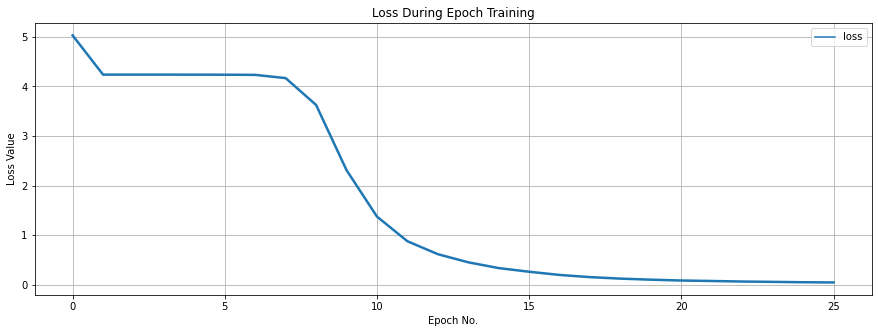

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pytorch = pd.DataFrame({"loss": loss})
plt.figure(figsize=(15,5))
plt.grid()
plt.xlabel("Epoch No.")
plt.ylabel("Loss Value")
plt.title("Loss During Epoch Training")
sns.lineplot(data=df_pytorch, palette="tab10", linewidth=2.5)

## Running all files

In [ ]:
def predict_function(model, data_loader):
    model.eval()
    fin_preds = []
    with torch.no_grad(): 
        for data in data_loader:
            for k, v in data.items():
                data[k] = v.to(DEVICE)
            
            batch_preds, _ = model(**data)
            fin_preds.append(batch_preds)

        return fin_preds

In [40]:
def clean_decoded_predictions(unclean_predictions):
    cleaned_predictions = []
    for i in unclean_predictions:
        if i != "-":
            cleaned_predictions.append(i)
            
    cleaned_predictions = "".join(cleaned_predictions)
    
    if len(cleaned_predictions) == 10:
        return cleaned_predictions   
    
    else:
        prev = "-"
        new_cleaned_predictions = []
        for char in cleaned_predictions:
            if char == prev:
                continue
            new_cleaned_predictions.append(char)
            prev = char
        res = "".join(new_cleaned_predictions)
        return res
    
def predict_captcha(model, eval_loader, image_path):
    plt.figure(figsize=(15,5))
    image = mpimg.imread(image_path[0])
    target = image_path[0].split("/")[-1].split(".")[0]
    plt.title(image_path[0].split("/")[-1])
    plt.imshow(image)
    
    valid_preds = predict_function(model, eval_loader)
    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
    
    preds = clean_decoded_predictions(current_preds[0])
    
    success = True if preds == target else False


    return{
        "success": success,
        "prediction": preds,
        "real": target
    }

In [36]:
tot = 0
cor = 0
dfFalse = []
for i in df["paths"]:
  #img = random.choice(i)
  img = [i]
  print(img)
  eval_dataset = DatasetClassifier(
      image_paths=img, targets=[np.array([x for x in np.arange(10)])], resize=(IMG_HEIGHT, IMG_WIDTH)
  )

  eval_loader = torch.utils.data.DataLoader(
      eval_dataset,
      batch_size=BATCH_SIZE,
      num_workers=NUM_WORKERS,
      shuffle=False
  )

  image_path = img
  preds = predict_captcha(model, eval_loader, image_path)
  if preds["success"] == True:
    cor = cor + 1
  else:
    dfFalse.append(i)
  tot = tot + 1
  print(tot)
  if tot == 100:
    break
  print(preds)

['Dataset/j7UD7X7DO6.jpg']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1
{'success': True, 'prediction': 'j7UD7X7DO6', 'real': 'j7UD7X7DO6'}
['Dataset/9sATSPOX60.jpg']
2
{'success': True, 'prediction': '9sATSPOX60', 'real': '9sATSPOX60'}
['Dataset/f159NWHxnv.jpg']
3
{'success': True, 'prediction': 'f159NWHxnv', 'real': 'f159NWHxnv'}
['Dataset/byYBCP5YE1.jpg']
4
{'success': True, 'prediction': 'byYBCP5YE1', 'real': 'byYBCP5YE1'}
['Dataset/52l00PM9hS.jpg']
5
{'success': True, 'prediction': '52l00PM9hS', 'real': '52l00PM9hS'}
['Dataset/Z68c51Xt0Z.jpg']
6
{'success': True, 'prediction': 'Z68c51Xt0Z', 'real': 'Z68c51Xt0Z'}
['Dataset/hrDY7K38G4.jpg']
7
{'success': True, 'prediction': 'hrDY7K38G4', 'real': 'hrDY7K38G4'}
['Dataset/wiHtpqSBr3.jpg']
8
{'success': True, 'prediction': 'wiHtpqSBr3', 'real': 'wiHtpqSBr3'}
['Dataset/tkI8sccJxU.jpg']
9
{'success': True, 'prediction': 'tkI8sccJxU', 'real': 'tkI8sccJxU'}
['Dataset/85ECT92R9i.jpg']
10
{'success': True, 'prediction': '85ECT92R9i', 'real': '85ECT92R9i'}
['Dataset/y35tV6u4zU.jpg']
11
{'success': True, 'predict

In [37]:
dfFalse

['Dataset/9i8D23uDtw.jpg',
 'Dataset/m1t0H9E7ZD.jpg',
 'Dataset/x1K7V807x3.jpg',
 'Dataset/Q558d4m5qD.jpg',
 'Dataset/WMibT185Ub.jpg',
 'Dataset/S3cnFF2ZTc.jpg',
 'Dataset/1hQAfesHe1.jpg',
 'Dataset/fqLTPKZZ1b.jpg']

In [38]:
accuracy = cor/tot
accuracy = accuracy * 100
print("accuracy = ", accuracy)

accuracy =  92.0


### True Prediction

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'success': True, 'prediction': '9V2CK1g1ME', 'real': '9V2CK1g1ME'}


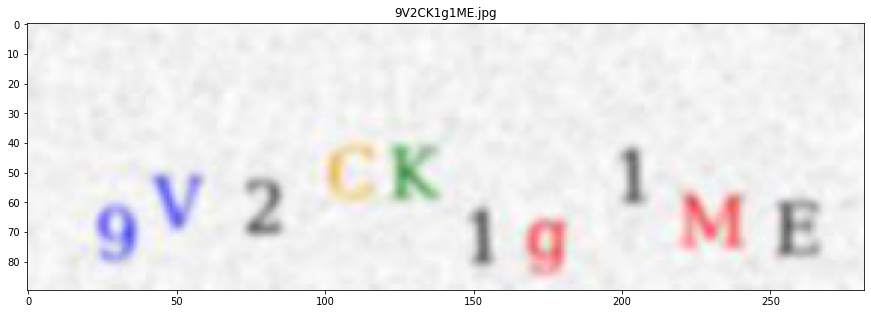

In [44]:
image_path = ['Dataset/9V2CK1g1ME.jpg']

img = image_path
eval_dataset = DatasetClassifier(
    image_paths=img, targets=[np.array([x for x in np.arange(10)])], resize=(IMG_HEIGHT, IMG_WIDTH)
)

eval_loader = torch.utils.data.DataLoader(
    eval_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

preds = predict_captcha(model, eval_loader, image_path)
print(preds)

### False Prediction

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'success': False, 'prediction': 'i8D233uDtw', 'real': '9i8D23uDtw'}


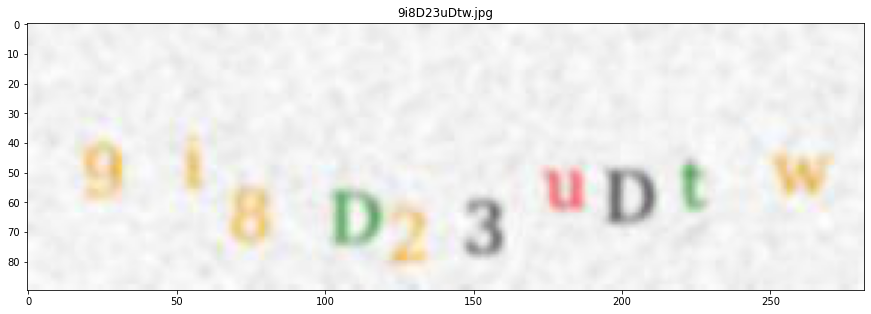

In [45]:
image_path = ['Dataset/9i8D23uDtw.jpg']

img = image_path
eval_dataset = DatasetClassifier(
    image_paths=img, targets=[np.array([x for x in np.arange(10)])], resize=(IMG_HEIGHT, IMG_WIDTH)
)

eval_loader = torch.utils.data.DataLoader(
    eval_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

preds = predict_captcha(model, eval_loader, image_path)
print(preds)